# Chest X-Ray Images (Pneumonia) Classification

### Introduction
By Ziv Ben Zvi 203966643 and Julian Rubinstein 204907901.

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.
Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.

As mentioned above, a chest X-ray is a prominent and common way to identify pneumonia. Therefore, developing an accurate model for analyzing the results of a chest X-ray can be extremly helpful in succesfuly diagnosing pneumonia in patients. The following paper will discuss the development of such model and its subsuquent accuracy and efficacy in acomplishing this task. The learning proccess of this model uses the dataset provided in the kaggle competition [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/discussion) and will attempt to classify X-ray lung images to either normal or pneumonia. The dataset contains 5,863 chest X-Ray RGB images (JPEG) divided into NORMAL or PNEUMONIA folders.

<img src="Inkedindex_LI.jpg">

### Imports

In [2]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import cv2

In [3]:
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Loading Data and Data Processing

We define the data paths, compress the images by resizing them and then load the data to a list of 2d np arrays which represnt the images:

In [4]:
#NORMAL_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/NORMAL'
#PNEUMONIA_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/PNEUMONIA'
NORMAL_PATH = 'chest_xray/DATA/NORMAL'
PNEUMONIA_PATH = 'chest_xray/DATA/PNEUMONIA'

DATA_NUM=1000

NORMAL_FILES = glob(NORMAL_PATH + "/*.jpeg")
PNEUMONIA_FILES = glob(PNEUMONIA_PATH + "/*.jpeg")

normal_data = []
pneumonia_data = []

for file in tqdm(NORMAL_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    normal_data.append(image)

for file in tqdm(PNEUMONIA_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    pneumonia_data.append(image)

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/4265 [00:00<?, ?it/s]

Let's print the size of both datasets and the shapes of the images:

In [5]:
print("Number of healthy patients images: " + str(len(normal_data)))
print("Number of sick patients images: " + str(len(pneumonia_data)))
print("Healthy image 1 shape: " + str(normal_data[0].shape))
print("Sick image 1 shape: " + str(pneumonia_data[0].shape))

Number of healthy patients images: 1575
Number of sick patients images: 4265
Healthy image 1 shape: (60, 100, 3)
Sick image 1 shape: (60, 100, 3)


Two things can be observed - Firstly, the shape of the images is 60X100X3, as expected following the compression done above and the fact the images are all RGB images. Secondly, we can see that the data contains approximatly 3 times the amount of sick images to healthy images, that is something that should be taken note of as it can affect the training of the model.

Next, in observing the images, it can be noticed that although the images are in RGB format, all the colors appear to be entirely greyscaled. In the following blocks of code we will check the possibility of converting the images to greyscale to both reduce the file-size of the images (which will make the model training faster) and to reduce the complexity of the images which will ease the process of image analysis.

Firstly, lets observe an image before and after converting it to greyscale format:

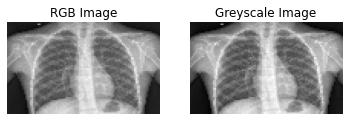

In [6]:
normal_image = normal_data[0]
gray_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,2)

ax[0].imshow(normal_image)
ax[0].set_title('RGB Image')
ax[0].axis('off')

ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title('Greyscale Image')
ax[1].axis('off')

plt.show()

In [7]:
print("Before conversion shape: " + str(normal_data[0].shape))
print("After conversion shape: " + str(gray_image.shape))

Before conversion shape: (60, 100, 3)
After conversion shape: (60, 100)


As expected, it can be clearly seen that the conversion to grayscale hardly affects the visual of the image, if at all. As such, we will proceed to convert all images to grayscale format:

In [8]:
for index, image in enumerate(normal_data):
    normal_data[index] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
for index, image in enumerate(pneumonia_data):
    pneumonia_data[index] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### EDA

As a first step, lets simply observe a number of images of healthy patients and sick patients to see if we can point out any visual difference.

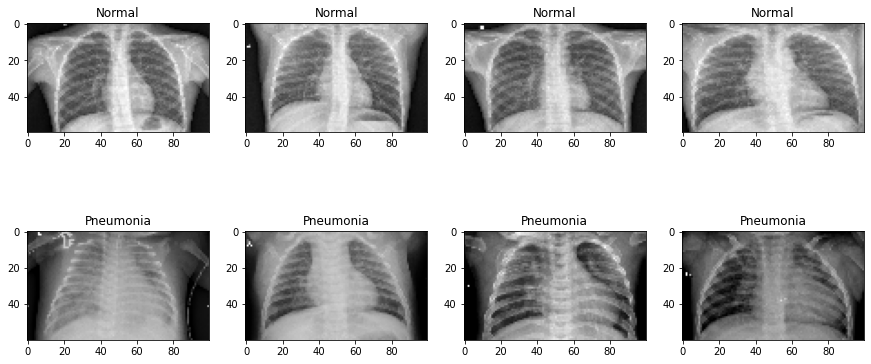

In [9]:
plt.rcParams["figure.figsize"] = (15,7)
fig, axis = plt.subplots(2,4)


for index, image in enumerate(normal_data[:4]):
    axis[0,index].imshow(image, cmap="gray")
    axis[0,index].set_title('Normal')
    
    
for index, image in enumerate(pneumonia_data[:4]):
    axis[1,index].imshow(image, cmap="gray")
    axis[1,index].set_title('Pneumonia')

    
plt.show()

By first examination, a slight difference of opacity within the ribcage can be noticed between the normal and the pneumonia-induced images. The pneumonia images appear to have a more cloudy color as opposed to the more transparent normal images (especially in the bottom left image that can be seen above).

Since these images are already converted to grey-scale, we can observe the single color distribution of the images and the mean pixel values:

<AxesSubplot:title={'center':'pneumonia'}, ylabel='Count'>

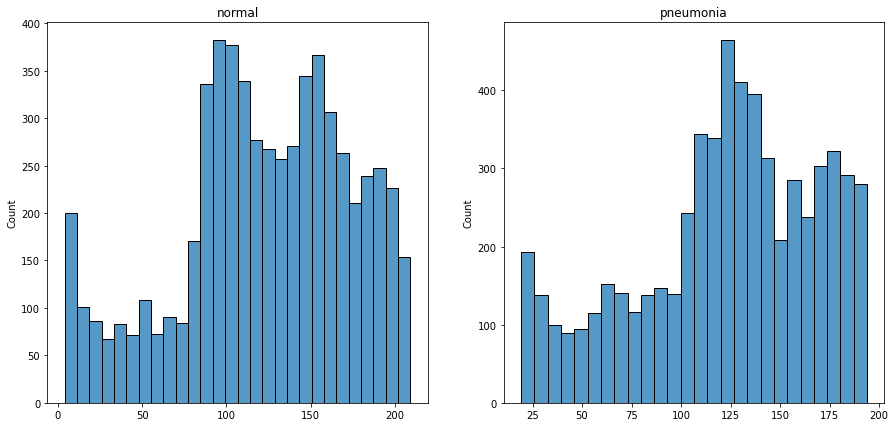

In [10]:
normal_dist = 0
normal_flattened = []

for image in normal_data:
    normal_flattened.append(image.flatten())

for image in normal_flattened:
    normal_dist += image/len(normal_data)

pneumonia_dist = 0
pneumonia_flattened = []

for image in pneumonia_data:
    pneumonia_flattened.append(image.flatten())

for image in pneumonia_flattened:
    pneumonia_dist += image/len(pneumonia_data)

plt.subplot(1, 2, 1)
plt.title('normal')
sns.histplot(normal_dist)

plt.subplot(1, 2, 2)
plt.title('pneumonia')
sns.histplot(pneumonia_dist)

A slight difference of shape between the distributions can be seen, however, nothing clear enough that can be pointed out without the use of more advanced tools. Lets observe the mean and median pixel values:

In [11]:

print(f"The mean pixel value of NORMAL images: {int(np.mean(normal_data))}")
print(f"The mean pixel value of PNEUMONIA images: {int(np.mean(pneumonia_data))}")

print(f"\nThe median pixel value of NORMAL images: {int(np.median(normal_data))}")
print(f"The median pixel value of PNEUMONIA images: {int(np.median(pneumonia_data))}")

print(f"\nThe standard deviation of the pixel value of NORMAL images: {int(np.std(normal_data))}")
print(f"The standard deviation of the pixel value of PNEUMONIA images: {int(np.std(pneumonia_data))}")

The mean pixel value of NORMAL images: 122
The mean pixel value of PNEUMONIA images: 122

The median pixel value of NORMAL images: 132
The median pixel value of PNEUMONIA images: 134

The standard deviation of the pixel value of NORMAL images: 62
The standard deviation of the pixel value of PNEUMONIA images: 59


As can be clearly seen, the mean and median pixel values are extremly close and are well in the standard deviation of the pixel distribution. As such, this is not an avenue that will help the analysis.

### PCA

We will start by defining our pca model and compiling it on our combined dataset of images of both the pneumonia and normal images: 

In [12]:
combined_pca = sklearn.preprocessing.StandardScaler().fit_transform(normal_flattened + pneumonia_flattened)
pca = sklearn.decomposition.PCA(n_components = 6)
pca.fit(combined_pca)
combined_reduced = pca.transform(combined_pca)
combined_pca_df = pd.DataFrame(data=combined_reduced,columns=['PC1','PC2','PC3','PC4','PC5','PC6'] )
combined_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-11.739896,20.709378,33.057159,-3.488357,10.704594,36.682053
1,-47.465511,-12.719462,17.865604,4.914026,-12.638005,10.979804
2,-22.774161,23.508688,37.292039,9.330606,13.611014,19.671530
3,-35.245922,54.317781,30.141209,14.385781,-13.055854,0.495196
4,-25.918642,27.331506,38.633686,20.172815,14.768848,12.066361


explained variance ratio (first three components): [0.29068861 0.09298998 0.06840393]
sum of first three components: 0.452083


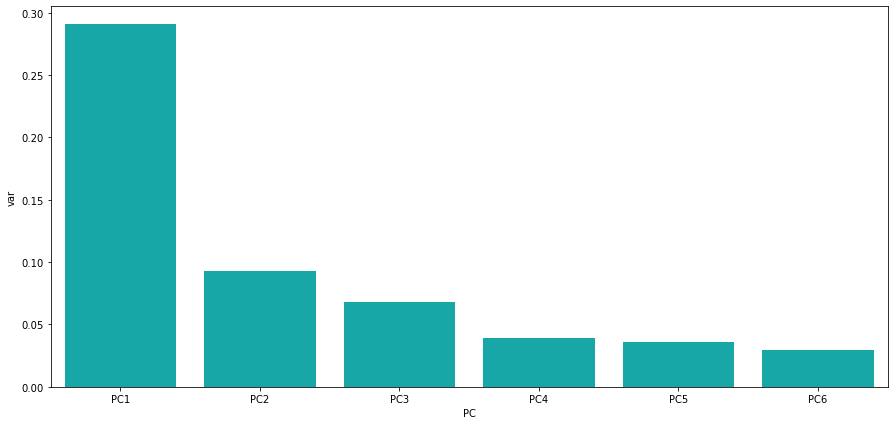

In [13]:
pca.explained_variance_ratio_

df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['PC1','PC2','PC3','PC4','PC5','PC6']})
sns.barplot(x='PC',y="var",data=df, color="c");

print('explained variance ratio (first three components): %s' % str(pca.explained_variance_ratio_[:3]))
print('sum of first three components: %f' % float(sum(pca.explained_variance_ratio_[:3])))

We can see that the first PC contains about a third of the variance in the images while the first three combined hold almost half of all the variance between the images. We will now proceed to divide the images based on their PC scores and see if any of them will show a pattern of normal/pneumonia images. All PCs will be shown with the first 2 rows of images corresponding to the higest score and the second 2 rows will correspond to the low pc score.

#### First PC

In [14]:
highest_score_ids = np.argpartition(combined_reduced[:, 0], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 0], 8)[:8]

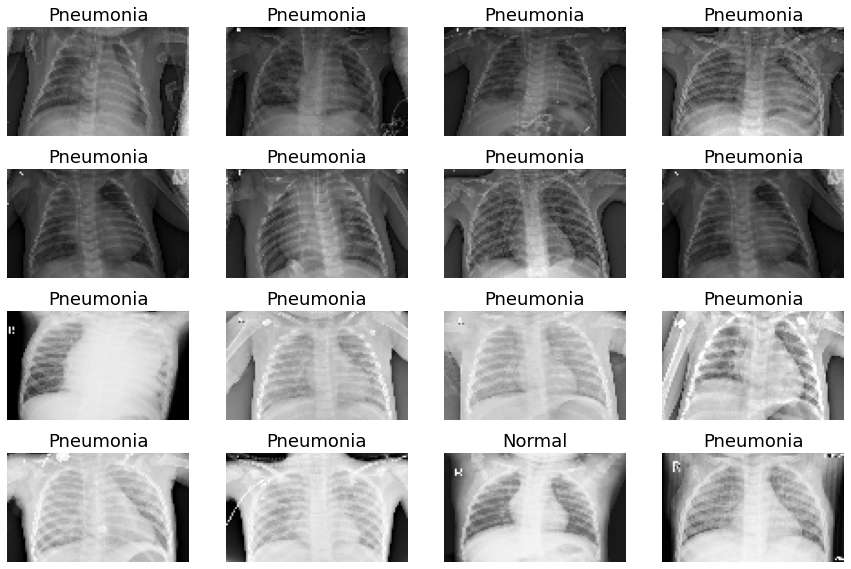

In [15]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

It can be clearly seen that the first PC is that of the total brightness of the images (the mean value of the pixels of the images). It can be noticed that both the first two rows (lowest score) and the last two rows (highest score) are both entirely made of pneumonia images, as such, this PC does not help our classification.

#### Second PC

In [16]:
highest_score_ids = np.argpartition(combined_reduced[:, 1], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 1], 8)[:8]

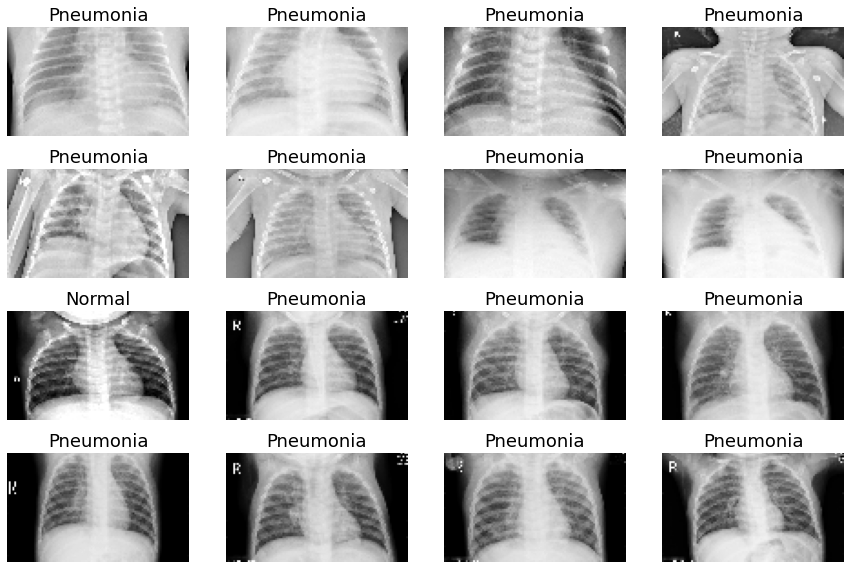

In [17]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

Similar to the first PC, this PC doesn't help us very much as all rows are consisted of entirely pneumonia images.

#### Third PC

In [18]:
highest_score_ids = np.argpartition(combined_reduced[:, 2], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 2], 8)[:8]

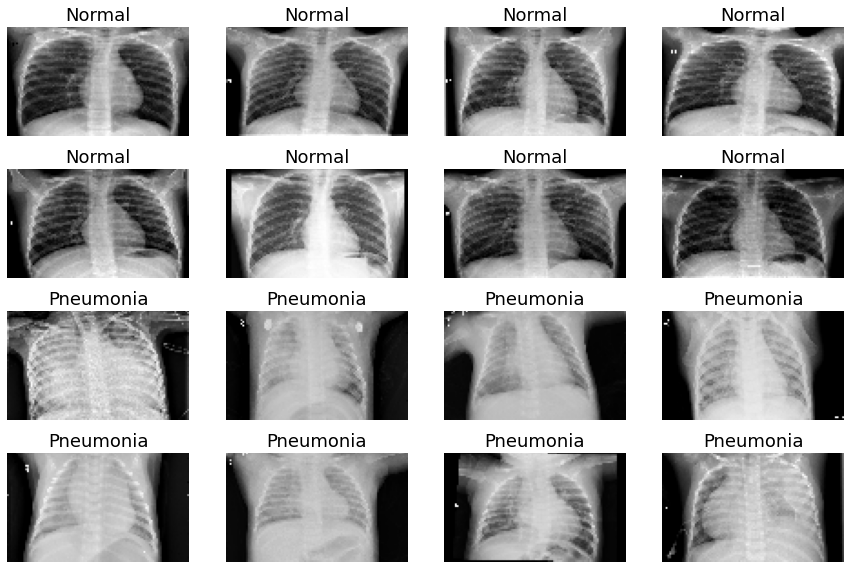

In [19]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

Jackpot! This PC has managed to completly divide between the pneumonia images and the normal images with an accuracy of 100% for 16 images. This has to be taken seriously and will be further investigated as a classifcation tool in a few sections.

##### Fourth PC

In [139]:
highest_score_ids = np.argpartition(combined_reduced[:, 3], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 3], 8)[:8]

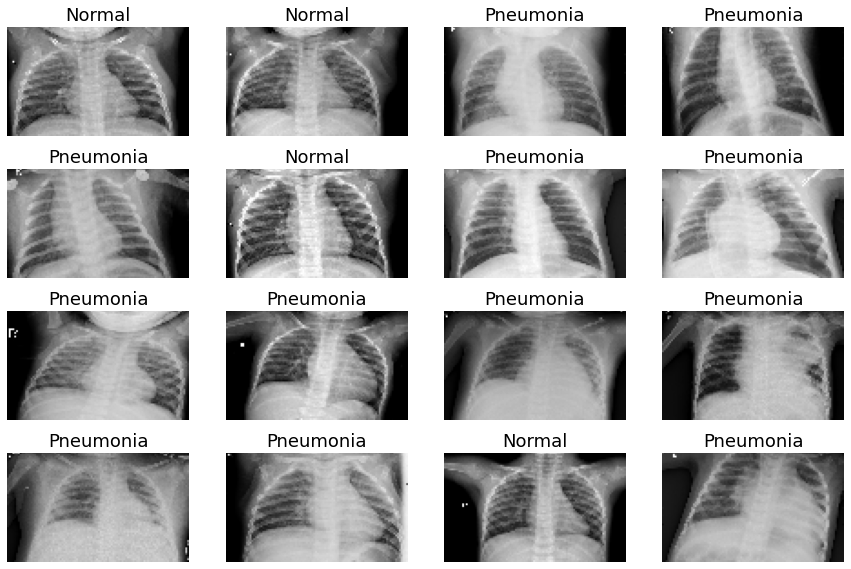

In [140]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

It does'nt look like this PC helps us very much, especially after the results of third pc. The distribution is almost equal between normal and pneumonia images in the first two rows and the last two rows. 

##### Fifth PC

In [22]:
highest_score_ids = np.argpartition(combined_reduced[:, 4], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 4], 8)[:8]

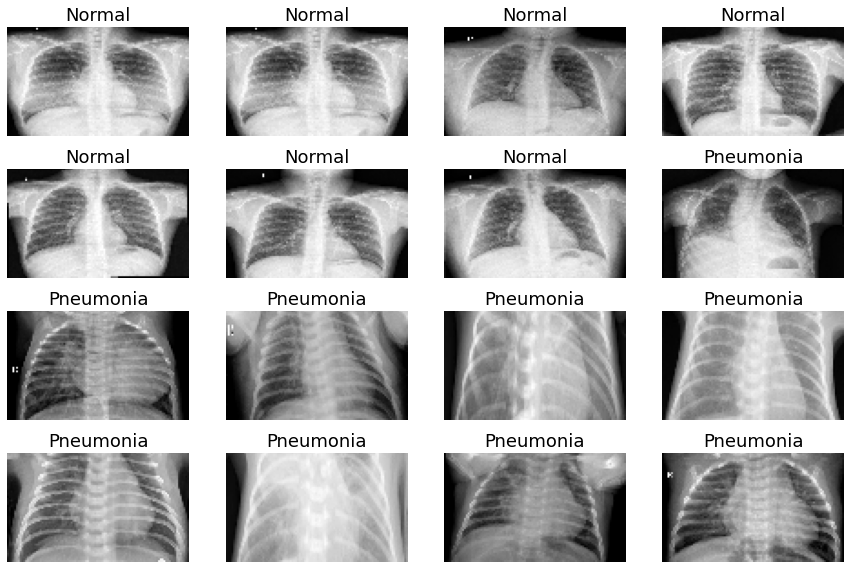

In [23]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

Wow! again we managed to find a PC that classifies the images with almost 100% accuracy. This PC will be considered as well as a classification tool for our images. 

##### Sixth PC

In [24]:
highest_score_ids = np.argpartition(combined_reduced[:, 5], -8)[-8:]
lowest_score_ids = np.argpartition(combined_reduced[:, 5], 8)[:8]

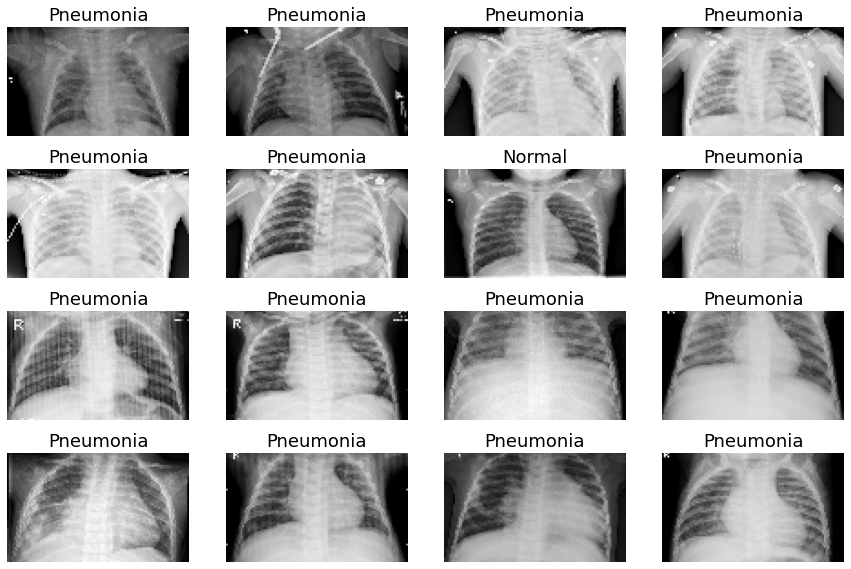

In [25]:
plt.figure(figsize=(15,10))
combined_images = normal_data + pneumonia_data
labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
    img = combined_images[ids]
    plt.subplot(4,4,num+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.title(f"{labels[ids]}",fontsize=18)

Similar to the first two PCs, we didn't get much from this PC and we will focus on the PCs that performed the best in classifying our images to normal and pneumonia.

Eventhough we want to believe that our PCs can classify our images according to the results we just had, we can't really know their accuracy before further exploring them.<br> We know that when examining only 16 images for every PC, while the images are being taken from the highest and lowest score of the PC, it's not enough as a classification tool. Especially when we know that among all images of those PC, the more we will check closer to the median scores of the PCs and away from the highest and lowest scores it will be harder to predict the condition accuartly. 

Let's test our real PCs accuracy:

##### Testing the pca  

In [142]:
def print_pca_group_variation(pca_num):

    ## TOTAL IMAGES -> 5840
    
    normal_count = 0
    pneumonia_count = 0
    NORMAL_LENGTH = len(normal_data) #1575
    PNEUMONIA_LENGTH = len(pneumonia_data) # 4275
    MEAN = int((NORMAL_LENGTH + PNEUMONIA_LENGTH)/2)

    first_group_prediction_ids = np.argpartition(combined_reduced[:, pca_num], -NORMAL_LENGTH)[-NORMAL_LENGTH:]
    second_group_prediction_ids = np.argpartition(combined_reduced[:, pca_num], PNEUMONIA_LENGTH)[:PNEUMONIA_LENGTH]

    labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)


    for first_index in first_group_prediction_ids:
        if labels[first_index] == "Normal":
            normal_count += 1

    for second_index in second_group_prediction_ids:
        if labels[second_index] == "Pneumonia":
            pneumonia_count += 1
            
    first_group_accuracy = int(100*normal_count/NORMAL_LENGTH)
    second_group_accuracy = int(100*pneumonia_count/PNEUMONIA_LENGTH)
    total_accuracy = int((first_group_accuracy * NORMAL_LENGTH + second_group_accuracy * PNEUMONIA_LENGTH) / (NORMAL_LENGTH + PNEUMONIA_LENGTH ))
    
    print(f"According to PCA - {pca_num}, the first group contains: {first_group_accuracy} % normal images")
    print(f"According to PCA - {pca_num}, the second group contains: {second_group_accuracy} % pneumonia images")
    print(f"According to PCA - {pca_num}, the total accuracy is: {total_accuracy} % \n")

In [143]:
print_pca_group_variation(0)
print_pca_group_variation(1)
print_pca_group_variation(2)
print_pca_group_variation(3)
print_pca_group_variation(4)
print_pca_group_variation(5)

According to PCA - 0, the first group contains: 18 % normal images
According to PCA - 0, the second group contains: 69 % pneumonia images
According to PCA - 0, the total accuracy is: 55 % 

According to PCA - 1, the first group contains: 8 % normal images
According to PCA - 1, the second group contains: 66 % pneumonia images
According to PCA - 1, the total accuracy is: 50 % 

According to PCA - 2, the first group contains: 63 % normal images
According to PCA - 2, the second group contains: 86 % pneumonia images
According to PCA - 2, the total accuracy is: 79 % 

According to PCA - 3, the first group contains: 26 % normal images
According to PCA - 3, the second group contains: 73 % pneumonia images
According to PCA - 3, the total accuracy is: 60 % 

According to PCA - 4, the first group contains: 36 % normal images
According to PCA - 4, the second group contains: 76 % pneumonia images
According to PCA - 4, the total accuracy is: 65 % 

According to PCA - 5, the first group contains: 41 

The total accuracy of our third PC is quite impressive. We managed to find a classifying tool, without any complex models, that perform with accuracy of 79%!! 

##### Basic Classification (K-means, KNN)

### Data Preperation

Before feeding the data to the model we need to perform various manipulations to conform to the format required by the neural network. The following blocks of code will describe this process.

Firstly, the values of the pixels are normalized from (0,255) to (0,1):

In [40]:
print("Image before normalization: \n" + str(normal_data[0]))

for index, image in enumerate(normal_data):
    normal_data[index] = image / 255
    
for index, image in enumerate(pneumonia_data):
    pneumonia_data[index] = image / 255

print("\n\n Image after normalization: \n" + str(normal_data[0]))

Image before normalization: 
[[31 32 30 ... 34 30 35]
 [30 31 28 ... 32 33 32]
 [30 34 30 ... 29 31 34]
 ...
 [30 28 30 ... 33 35 35]
 [31 29 27 ... 34 33 36]
 [30 27 27 ... 34 34 35]]


 Image after normalization: 
[[0.12156863 0.1254902  0.11764706 ... 0.13333333 0.11764706 0.1372549 ]
 [0.11764706 0.12156863 0.10980392 ... 0.1254902  0.12941176 0.1254902 ]
 [0.11764706 0.13333333 0.11764706 ... 0.11372549 0.12156863 0.13333333]
 ...
 [0.11764706 0.10980392 0.11764706 ... 0.12941176 0.1372549  0.1372549 ]
 [0.12156863 0.11372549 0.10588235 ... 0.13333333 0.12941176 0.14117647]
 [0.11764706 0.10588235 0.10588235 ... 0.13333333 0.13333333 0.1372549 ]]


Following that, we would like to flatten the images, as this way it is easier to feed the images to the model. This will be done with the numpy flatten method. Then we would like to turn the list of images to an np array:

In [52]:
print("Before flattening: " + str(normal_data[0]))

for index, image in enumerate(normal_data):
    normal_data[index] = image.flatten()
    
for index, image in enumerate(pneumonia_data):
    pneumonia_data[index] = image. flatten()

print("After flattening: " + str(normal_data[0])) 

images = np.array(normal_data + pneumonia_data)

Before flattening: [0.12156863 0.1254902  0.11764706 ... 0.13333333 0.13333333 0.1372549 ]
After flattening: [0.12156863 0.1254902  0.11764706 ... 0.13333333 0.13333333 0.1372549 ]


Then we would like to create the X data and Y data for the model. This will consist a number of steps:
1. Define vectors of length of the pneumonia data and normal data with values 0 or 1 corresponding to the either a healthy or sick patient respectively
2. Transfer these vectors from single valued to categorical: [0,1,1,0] -> [[1,0], [0,1], [0,1], [1,0]]
3. Turn the vectors to np arrays

In [53]:
normal_Y = [0]*len(normal_data)
pneumonia_Y = [1]*len(pneumonia_data)

image_labels = to_categorical(normal_Y + pneumonia_Y)

images_labels = np.array(image_labels)

Finally, we would like divide the dataset to X_train, X_test, y_train, y_test using the train_test_split function of sklearn with a ratio of 0.2:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, images_labels, test_size=0.2)

### Basic neural network

After finishing with the data preperation it is finally time to create the model and train it on the data. The first step will be to build the neural network:

In [54]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(100*60,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               3072512   
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
__________

The model is then compiled and fit to the data:

In [57]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=30,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test, y_test))


score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 4672 samples, validate on 1168 samples
Epoch 1/30
4672/4672 [==============================] - 2s 455us/sample - loss: 0.1719 - acc: 0.9341 - val_loss: 0.1580 - val_acc: 0.9443
Epoch 2/30
4672/4672 [==============================] - 1s 259us/sample - loss: 0.1487 - acc: 0.9431 - val_loss: 0.1503 - val_acc: 0.9443
Epoch 3/30
4672/4672 [==============================] - 1s 260us/sample - loss: 0.1472 - acc: 0.9399 - val_loss: 0.1710 - val_acc: 0.9358
Epoch 4/30
4672/4672 [==============================] - 1s 256us/sample - loss: 0.1549 - acc: 0.9386 - val_loss: 0.1776 - val_acc: 0.9272
Epoch 5/30
4672/4672 [==============================] - 1s 269us/sample - loss: 0.1420 - acc: 0.9452 - val_loss: 0.1734 - val_acc: 0.9366
Epoch 6/30
4672/4672 [==============================] - 1s 262us/sample - loss: 0.1397 - acc: 0.9463 - val_loss: 0.1501 - val_acc: 0.9452
Epoch 7/30
4672/4672 [==============================] - 1s 260us/sample - loss: 0.1614 - acc: 0.9362 - val_loss: 0.1588 - va

The results are great. We are looking on a model that classifies normal and pneumonia images with an accuracy of 93%

### Convolutional Neural Network

### Transfer Learning